In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
import os
import torch 
import torchvision
from torch import nn
import torch.nn.functional as F 
from torch.utils.data import DataLoader, random_split 
from torchvision import transforms 
import matplotlib.pyplot as plt 
import numpy as np 
import torch.optim as optim

In [3]:
# setting a random seed
np.random.seed(42)
torch.manual_seed(42)

In [4]:
# data preprocessing
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # For 3 channels (RED, GREEN, BLUE) normalizing with mean 0.5 and standard deviation 0.5

# Download the dataset
train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Split the training dataset into training and validation

size_validset = 10000
size_trainset = len(train)-size_validset
train_set, valid_set = random_split(train, [size_trainset, size_validset])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True, num_workers=2)

# Visualization

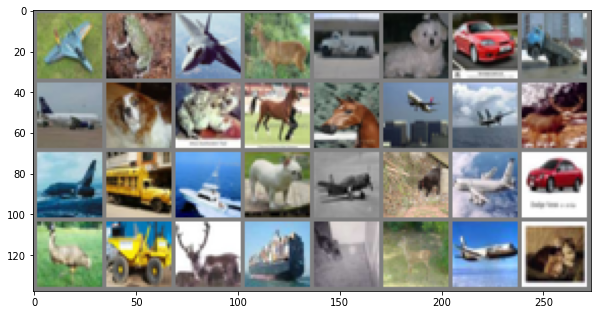

plane  frog plane  deer


In [6]:
# functions to show an image
def imshow(image):
    image = image / 2 + 0.5     # unnormalize
    npimage = image.numpy()
    fig,ax = plt.subplots(figsize = (10,12))
    plt.imshow(np.transpose(npimage, (1, 2, 0)))
    plt.show()

# getting random images
dataiter = iter(train_loader)
images, labels = dataiter.next()  # it will return the next item in the sequence

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Baseline CNN

In [7]:
def baseline():
    baseline_model=nn.Sequential(
    nn.Conv2d(3,32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
        
    nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
        
    nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
        
    nn.Flatten(),
    nn.Linear(32*4*4, 10),  
    nn.Softmax(dim=1)
    )
    
    classification_loss = nn.CrossEntropyLoss() # Usually for classification problems we use CrossEntropy

    return baseline_model, classification_loss

baseline_model, classification_loss = baseline()

In [8]:
def optimizers(model, opt, learning_rate, momentum_value=0):
    
    if opt == "SGD":
        model_optimizer = optim.SGD(model.parameters(), learning_rate, momentum=momentum_value)
        
    elif opt== "Adam":
        model_optimizer = optim.Adam(model.parameters(), learning_rate)
    
    return model_optimizer

In [ ]:
# # Defining two different optimizers: with and without momentum

# optimizer=optimizers(model=base_model, opt="SGD", learning_rate=0.01)

# optimizer_w_momentum=optimizers(model=base_model, opt="SGD", learning_rate=0.01, momentum_value=0.9)

In [9]:
# Used colab for this assignment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline_model.to(device)
print(device)

cuda


In [10]:
# model training function
def train(loader, model, classify_loss, opt):   
    total = 0
    correct = 0
    running_loss = 0.0
    model.train()   

    for i, data in enumerate(loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        opt.zero_grad()  

        # optimizer / forward / backward
        outputs = model(inputs)
        loss = classify_loss(outputs, labels)
        loss.backward()
        opt.step()      
        running_loss += loss.item()   # Loss
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item() 

    running_loss = running_loss / len(loader)
    accuracy=correct/total  
    return running_loss, accuracy

In [11]:
# We dont need backpropagation here for validation
def validation(loader, model, classify_loss, opt):
    with torch.no_grad():
        total = 0
        correct = 0
        running_loss = 0.0
        model.eval()

        for i, data in enumerate(loader):
          # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
          # optimizer / forward
            outputs = model(inputs)
            loss = classify_loss(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item() 

        running_loss = running_loss / len(loader)
        accuracy=correct/total
    
    return running_loss, accuracy

In [12]:
def metrics(opt, learning_rate):
    train_loss_list=[]
    train_acc_list=[]
    val_loss_list=[]
    val_acc_list=[]
    base_model, classification_loss = baseline()
    optimizer = optimizers(model=base_model, opt=opt, learning_rate=learning_rate)
    base_model = base_model.to(device)

    for epoch in range(20):
        train_loss,train_acc=train(loader=train_loader, model=base_model, classify_loss=classification_loss, opt=optimizer)
        val_loss,val_acc=validation(loader=valid_loader, model=base_model, classify_loss=classification_loss, opt=optimizer)

        print("Number of Epoch: ",epoch+1)
        print("\tTraining Loss: ",train_loss)
        print("\tTraining Accuracy: ",train_acc)

        print("\n\tValidation Loss",val_loss)
        print("\tValidation Accuracy",val_acc)

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, label="Training Loss")
    plt.plot(train_acc_list,label="Training Accuracy")
    plt.plot(val_loss_list, label="Validation Loss")
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,21,1))
    plt.legend(loc='center')
    plt.show
    
    return max(val_acc_list)  

In [13]:
def metrics_with_momentum(opt, learning_rate):
    
    train_loss_list=[]
    train_acc_list=[]
    val_loss_list=[]
    val_acc_list=[]
    
    base_model, classification_loss = baseline()
    optimizer=optimizers(model=base_model, opt=opt, learning_rate=learning_rate, momentum_value=0.9)
    
    base_model = base_model.to(device)

    for epoch in range(20):
        train_loss,train_acc=train(loader=train_loader, model=base_model, classify_loss=classification_loss, opt=optimizer)
        
        val_loss,val_acc=validation(loader=valid_loader, model=base_model, classify_loss=classification_loss, opt=optimizer)
       
        print("Epoch Number: ",epoch+1)
        print("\n\tTraining Loss: ",train_loss)
        print("\tTraining Accuracy: ",train_acc)
        
        print("\n\tValidation Loss",val_loss)
        print("\tValidation Accuracy",val_acc)

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, label="Training Loss")
    plt.plot(train_acc_list,label="Training Accuracy")
    plt.plot(val_loss_list, label="Validation Loss")
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy and Loss')
    plt.xticks(np.arange(1,21,1))
    plt.legend(loc='center')
    plt.show()
    
    return max(val_acc_list)

Number of Epoch:  1
	Training Loss:  2.302084506988525
	Training Accuracy:  0.11025

	Validation Loss 2.3013358710292047
	Validation Accuracy 0.1026
Number of Epoch:  2
	Training Loss:  2.299654937362671
	Training Accuracy:  0.100175

	Validation Loss 2.2963881165074844
	Validation Accuracy 0.101
Number of Epoch:  3
	Training Loss:  2.2830505338668825
	Training Accuracy:  0.12805

	Validation Loss 2.2622899430247543
	Validation Accuracy 0.1833
Number of Epoch:  4
	Training Loss:  2.2346598445892334
	Training Accuracy:  0.216675

	Validation Loss 2.2042608497241813
	Validation Accuracy 0.2529
Number of Epoch:  5
	Training Loss:  2.173970993423462
	Training Accuracy:  0.283475

	Validation Loss 2.1573667968043124
	Validation Accuracy 0.2971
Number of Epoch:  6
	Training Loss:  2.1475350012779235
	Training Accuracy:  0.30755

	Validation Loss 2.1336351248402945
	Validation Accuracy 0.3171
Number of Epoch:  7
	Training Loss:  2.1258195583343507
	Training Accuracy:  0.3302

	Validation Loss

0.4853

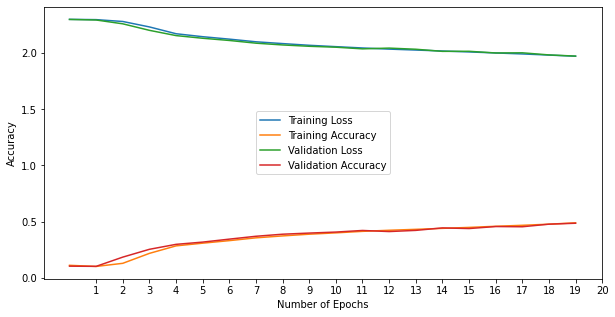

In [14]:
metrics("SGD", 0.01)

Epoch Number:  1

	Training Loss:  2.2041427035331727
	Training Accuracy:  0.238275

	Validation Loss 2.127676266831712
	Validation Accuracy 0.3249
Epoch Number:  2

	Training Loss:  2.0924000308036805
	Training Accuracy:  0.364225

	Validation Loss 2.061429832309199
	Validation Accuracy 0.3968
Epoch Number:  3

	Training Loss:  2.0428135491371155
	Training Accuracy:  0.414525

	Validation Loss 2.0216372119732937
	Validation Accuracy 0.4362
Epoch Number:  4

	Training Loss:  2.006866536140442
	Training Accuracy:  0.451375

	Validation Loss 1.98648353658926
	Validation Accuracy 0.4725
Epoch Number:  5

	Training Loss:  1.9739249329566955
	Training Accuracy:  0.485025

	Validation Loss 1.96597555003608
	Validation Accuracy 0.4934
Epoch Number:  6

	Training Loss:  1.948419508743286
	Training Accuracy:  0.509425

	Validation Loss 1.9509942154533946
	Validation Accuracy 0.5082
Epoch Number:  7

	Training Loss:  1.9246668382644654
	Training Accuracy:  0.5352

	Validation Loss 1.918881003849

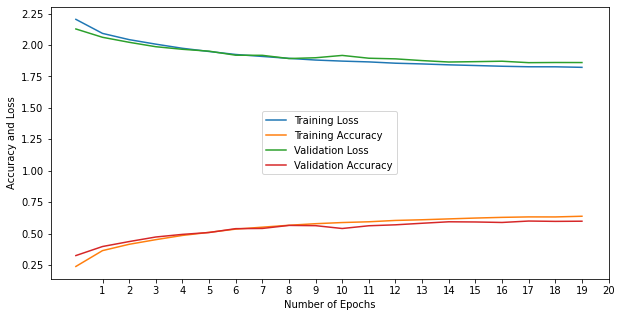

0.5995

In [15]:
metrics_with_momentum("SGD", 0.01)

Number of Epoch:  1
	Training Loss:  2.3025166399002077
	Training Accuracy:  0.11825

	Validation Loss 2.3025174986440153
	Validation Accuracy 0.1187
Number of Epoch:  2
	Training Loss:  2.3024531534194947
	Training Accuracy:  0.122175

	Validation Loss 2.302452419512569
	Validation Accuracy 0.1237
Number of Epoch:  3
	Training Loss:  2.3023888536453248
	Training Accuracy:  0.125325

	Validation Loss 2.302387069970274
	Validation Accuracy 0.127
Number of Epoch:  4
	Training Loss:  2.3023235431671143
	Training Accuracy:  0.129725

	Validation Loss 2.302316981001784
	Validation Accuracy 0.1305
Number of Epoch:  5
	Training Loss:  2.302256837654114
	Training Accuracy:  0.1316

	Validation Loss 2.302249551961978
	Validation Accuracy 0.1339
Number of Epoch:  6
	Training Loss:  2.3021881227493286
	Training Accuracy:  0.13545

	Validation Loss 2.302178507034009
	Validation Accuracy 0.1371
Number of Epoch:  7
	Training Loss:  2.3021170879364012
	Training Accuracy:  0.139

	Validation Loss 2.30

0.1818

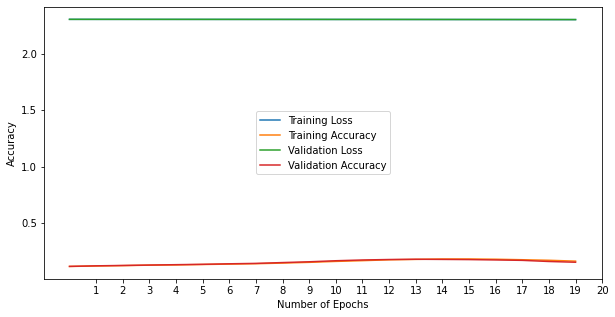

In [16]:
metrics("SGD", 0.001)

Epoch Number:  1

	Training Loss:  2.3021322761535643
	Training Accuracy:  0.12335

	Validation Loss 2.3015570968103867
	Validation Accuracy 0.1345
Epoch Number:  2

	Training Loss:  2.3007732978820803
	Training Accuracy:  0.1293

	Validation Loss 2.2991507548493697
	Validation Accuracy 0.1248
Epoch Number:  3

	Training Loss:  2.2943167499542234
	Training Accuracy:  0.1324

	Validation Loss 2.2819600691810584
	Validation Accuracy 0.1692
Epoch Number:  4

	Training Loss:  2.2425469528198243
	Training Accuracy:  0.208175

	Validation Loss 2.1956153738612945
	Validation Accuracy 0.2588
Epoch Number:  5

	Training Loss:  2.179030370426178
	Training Accuracy:  0.27525

	Validation Loss 2.1608330860686378
	Validation Accuracy 0.2956
Epoch Number:  6

	Training Loss:  2.1523924384117126
	Training Accuracy:  0.302825

	Validation Loss 2.1393060470922305
	Validation Accuracy 0.3167
Epoch Number:  7

	Training Loss:  2.1312231939315796
	Training Accuracy:  0.3248

	Validation Loss 2.11955596692

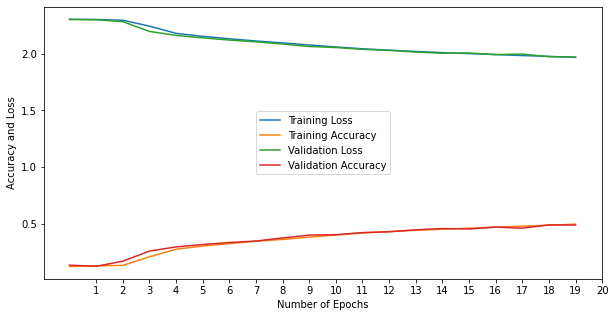

0.49

In [17]:
metrics_with_momentum("SGD", 0.001)

Number of Epoch:  1
	Training Loss:  2.2157474097251892
	Training Accuracy:  0.23045

	Validation Loss 2.1563477024864466
	Validation Accuracy 0.2977
Number of Epoch:  2
	Training Loss:  2.1083369824409486
	Training Accuracy:  0.347925

	Validation Loss 2.0694052411344486
	Validation Accuracy 0.3913
Number of Epoch:  3
	Training Loss:  2.05089332113266
	Training Accuracy:  0.407275

	Validation Loss 2.03192249654581
	Validation Accuracy 0.4245
Number of Epoch:  4
	Training Loss:  2.012256875896454
	Training Accuracy:  0.44615

	Validation Loss 2.000859391194182
	Validation Accuracy 0.4576
Number of Epoch:  5
	Training Loss:  1.9784962376594544
	Training Accuracy:  0.48

	Validation Loss 1.9915658121291822
	Validation Accuracy 0.4661
Number of Epoch:  6
	Training Loss:  1.9555023953437805
	Training Accuracy:  0.5029

	Validation Loss 1.9490441350510326
	Validation Accuracy 0.5085
Number of Epoch:  7
	Training Loss:  1.9338008631706238
	Training Accuracy:  0.525775

	Validation Loss 1.96

0.5715

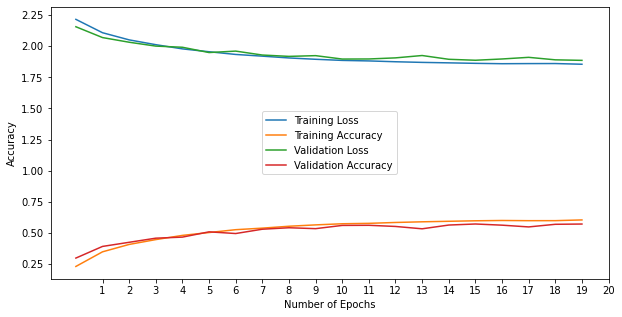

In [18]:
metrics("SGD", 0.1)

Epoch Number:  1

	Training Loss:  2.2822844095230104
	Training Accuracy:  0.17345

	Validation Loss 2.34433372409199
	Validation Accuracy 0.1169
Epoch Number:  2

	Training Loss:  2.339472356414795
	Training Accuracy:  0.121675

	Validation Loss 2.354817631145636
	Validation Accuracy 0.1064
Epoch Number:  3

	Training Loss:  2.358549026679993
	Training Accuracy:  0.1026

	Validation Loss 2.355817471830228
	Validation Accuracy 0.1054
Epoch Number:  4

	Training Loss:  2.3587749588012694
	Training Accuracy:  0.102375

	Validation Loss 2.3587147816301535
	Validation Accuracy 0.1025
Epoch Number:  5

	Training Loss:  2.3617758846282957
	Training Accuracy:  0.099375

	Validation Loss 2.3585151011189716
	Validation Accuracy 0.1025
Epoch Number:  6

	Training Loss:  2.3617758846282957
	Training Accuracy:  0.099375

	Validation Loss 2.3587147816301535
	Validation Accuracy 0.1025
Epoch Number:  7

	Training Loss:  2.3617758846282957
	Training Accuracy:  0.099375

	Validation Loss 2.35831542060

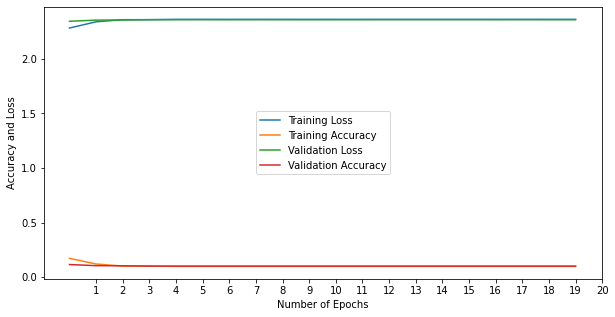

0.1169

In [19]:
metrics_with_momentum("SGD", 0.1)

Number of Epoch:  1
	Training Loss:  2.3609405546188356
	Training Accuracy:  0.100175

	Validation Loss 2.36121078801993
	Validation Accuracy 0.0999
Number of Epoch:  2
	Training Loss:  2.361125884628296
	Training Accuracy:  0.100025

	Validation Loss 2.361410468531112
	Validation Accuracy 0.0999
Number of Epoch:  3
	Training Loss:  2.361125884628296
	Training Accuracy:  0.100025

	Validation Loss 2.3611109477643386
	Validation Accuracy 0.0999
Number of Epoch:  4
	Training Loss:  2.361125884628296
	Training Accuracy:  0.100025

	Validation Loss 2.361410468531112
	Validation Accuracy 0.0999
Number of Epoch:  5
	Training Loss:  2.361125884628296
	Training Accuracy:  0.100025

	Validation Loss 2.361310628275521
	Validation Accuracy 0.0999
Number of Epoch:  6
	Training Loss:  2.361125884628296
	Training Accuracy:  0.100025

	Validation Loss 2.361310628275521
	Validation Accuracy 0.0999
Number of Epoch:  7
	Training Loss:  2.361125884628296
	Training Accuracy:  0.100025

	Validation Loss 2.

0.0999

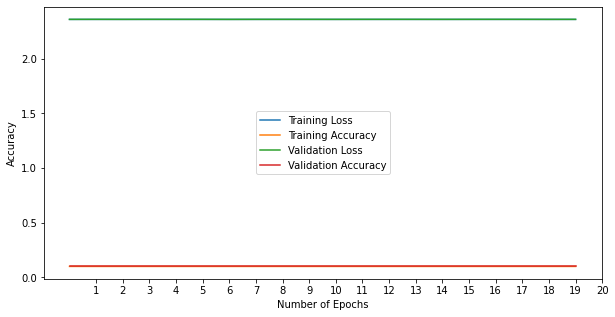

In [20]:
metrics("Adam", 0.01)

Number of Epoch:  1
	Training Loss:  2.0843200406074525
	Training Accuracy:  0.36995

	Validation Loss 2.0113770439982797
	Validation Accuracy 0.4455
Number of Epoch:  2
	Training Loss:  1.9610490566253662
	Training Accuracy:  0.4972

	Validation Loss 1.9317202194811056
	Validation Accuracy 0.5272
Number of Epoch:  3
	Training Loss:  1.9109521536827088
	Training Accuracy:  0.548425

	Validation Loss 1.9027431258759178
	Validation Accuracy 0.5539
Number of Epoch:  4
	Training Loss:  1.8745007185935973
	Training Accuracy:  0.584425

	Validation Loss 1.8852252236570413
	Validation Accuracy 0.5728
Number of Epoch:  5
	Training Loss:  1.8491831879615783
	Training Accuracy:  0.61055

	Validation Loss 1.8484971188127803
	Validation Accuracy 0.6098
Number of Epoch:  6
	Training Loss:  1.8251772783279419
	Training Accuracy:  0.63515

	Validation Loss 1.8367441317524773
	Validation Accuracy 0.6242
Number of Epoch:  7
	Training Loss:  1.8098196342468262
	Training Accuracy:  0.649575

	Validation 

0.6825

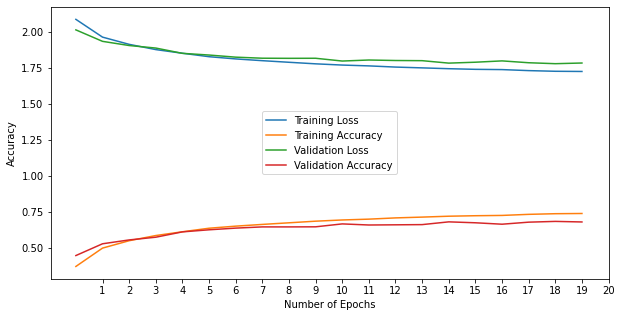

In [22]:
metrics("Adam", 0.001)

Number of Epoch:  1
	Training Loss:  2.362048740386963
	Training Accuracy:  0.099075

	Validation Loss 2.357716379074243
	Validation Accuracy 0.1035
Number of Epoch:  2
	Training Loss:  2.362025884628296
	Training Accuracy:  0.099125

	Validation Loss 2.357716379074243
	Validation Accuracy 0.1035
Number of Epoch:  3
	Training Loss:  2.362025884628296
	Training Accuracy:  0.099125

	Validation Loss 2.357616538818652
	Validation Accuracy 0.1035
Number of Epoch:  4
	Training Loss:  2.362025884628296
	Training Accuracy:  0.099125

	Validation Loss 2.357616538818652
	Validation Accuracy 0.1035
Number of Epoch:  5
	Training Loss:  2.362025884628296
	Training Accuracy:  0.099125

	Validation Loss 2.3574168583074697
	Validation Accuracy 0.1035
Number of Epoch:  6
	Training Loss:  2.362025884628296
	Training Accuracy:  0.099125

	Validation Loss 2.357716379074243
	Validation Accuracy 0.1035
Number of Epoch:  7
	Training Loss:  2.362025884628296
	Training Accuracy:  0.099125

	Validation Loss 2.

0.1035

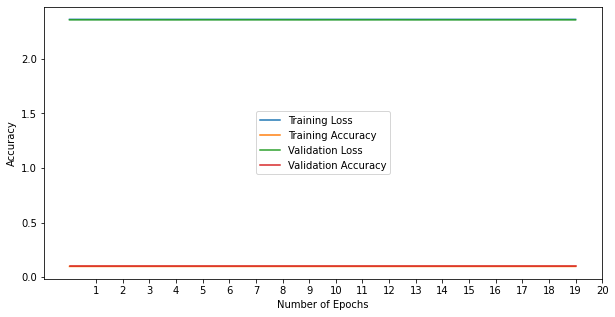

In [23]:
metrics("Adam", 0.1)

# Creating a different network

In [24]:
def new_network():
    model1=nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), 
    nn.ReLU(),
    nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),  
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),  
        
    nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1), 
    nn.ReLU(),
    nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(512,256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(256,128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(128,64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64,32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),

    nn.Flatten(),
    nn.Linear(32*2*2, 10),  
    nn.Softmax(dim=1)
    )

    classification_loss = nn.CrossEntropyLoss() # We usually use crossEntrophy loss for classification problems

    return model1, classification_loss

In [25]:
def new_metrics(optim,lr):   
    train_loss_list=[]
    train_acc_list=[]
    val_loss_list=[]
    val_acc_list=[]
    
    new_model, classification_loss_net1 = new_network()
    optimizer=optimizers(model=new_model, opt=optim, learning_rate=lr)
    new_model = new_model.to(device)

    for epoch in range(3):
        train_loss,train_acc=train(loader=train_loader, model=new_model, classify_loss=classification_loss_net1, opt=optimizer)
        
        val_loss,val_acc=validation(loader=valid_loader, model=new_model, classify_loss=classification_loss_net1, opt=optimizer)
       
        print("Epoch Number: ",epoch+1)
        print("\n\tTraining Loss: ",train_loss)
        print("\tTraining Accuracy: ",train_acc)
        
        print("\n\tValidation Loss",val_loss)
        print("\tValidation Accuracy",val_acc)

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, label="Training Loss")
    plt.plot(train_acc_list,label="Training Accuracy")
    plt.plot(val_loss_list, label="Validation Loss")
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy and Loss')
    plt.xticks(np.arange(0,4,1))
    plt.legend(loc='center right')
    plt.show()
    
    return max(val_acc_list)

Epoch Number:  1

	Training Loss:  2.3026076959609987
	Training Accuracy:  0.100925

	Validation Loss 2.3026254847407723
	Validation Accuracy 0.0963
Epoch Number:  2

	Training Loss:  2.3026009956359865
	Training Accuracy:  0.100925

	Validation Loss 2.3026395681947944
	Validation Accuracy 0.0963
Epoch Number:  3

	Training Loss:  2.3025972415924074
	Training Accuracy:  0.100925

	Validation Loss 2.3026567663247595
	Validation Accuracy 0.0963


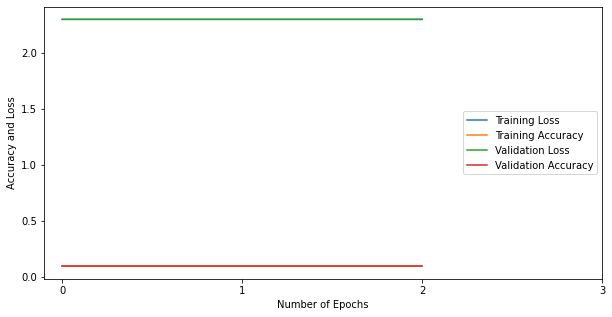

0.0963

In [26]:
new_metrics(optim='SGD',lr=0.1)

Epoch Number:  1

	Training Loss:  2.3025925788879396
	Training Accuracy:  0.100825

	Validation Loss 2.3026724014038478
	Validation Accuracy 0.0967
Epoch Number:  2

	Training Loss:  2.3025917837142944
	Training Accuracy:  0.100825

	Validation Loss 2.3026718179257912
	Validation Accuracy 0.0967
Epoch Number:  3

	Training Loss:  2.302591065979004
	Training Accuracy:  0.100825

	Validation Loss 2.302671889527537
	Validation Accuracy 0.0967


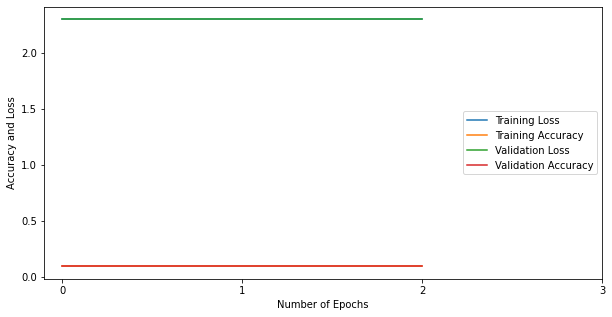

0.0967

In [27]:
new_metrics(optim='SGD',lr=0.01)

Epoch Number:  1

	Training Loss:  2.302594750404358
	Training Accuracy:  0.100825

	Validation Loss 2.3025858790729754
	Validation Accuracy 0.0967
Epoch Number:  2

	Training Loss:  2.302594646644592
	Training Accuracy:  0.100825

	Validation Loss 2.3025836114304514
	Validation Accuracy 0.0967
Epoch Number:  3

	Training Loss:  2.302594575881958
	Training Accuracy:  0.100825

	Validation Loss 2.3025832717030195
	Validation Accuracy 0.0967


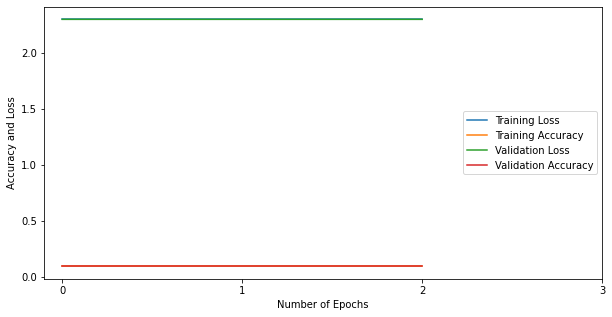

0.0967

In [28]:
new_metrics(optim='SGD',lr=0.001)

Epoch Number:  1

	Training Loss:  2.361124154090881
	Training Accuracy:  0.09995

	Validation Loss 2.361310628275521
	Validation Accuracy 0.0998
Epoch Number:  2

	Training Loss:  2.361100884628296
	Training Accuracy:  0.10005

	Validation Loss 2.361410468531112
	Validation Accuracy 0.0998
Epoch Number:  3

	Training Loss:  2.361100884628296
	Training Accuracy:  0.10005

	Validation Loss 2.361310628275521
	Validation Accuracy 0.0998


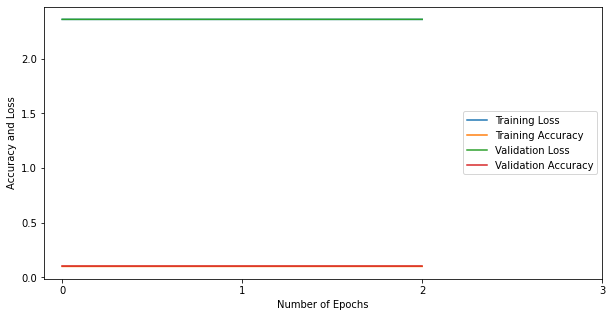

0.0998

In [29]:
new_metrics(optim='Adam',lr=0.1)

Epoch Number:  1

	Training Loss:  2.360857825279236
	Training Accuracy:  0.099875

	Validation Loss 2.361410468531112
	Validation Accuracy 0.0998
Epoch Number:  2

	Training Loss:  2.361100884628296
	Training Accuracy:  0.10005

	Validation Loss 2.361510308786703
	Validation Accuracy 0.0998
Epoch Number:  3

	Training Loss:  2.361100884628296
	Training Accuracy:  0.10005

	Validation Loss 2.361410468531112
	Validation Accuracy 0.0998


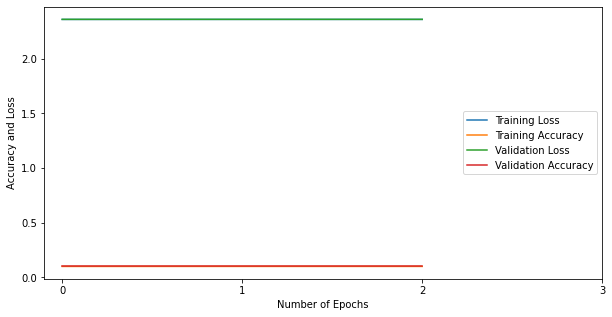

0.0998

In [30]:
new_metrics(optim='Adam',lr=0.01)

Epoch Number:  1

	Training Loss:  2.3106709831237793
	Training Accuracy:  0.13985

	Validation Loss 2.3647051969656165
	Validation Accuracy 0.0963
Epoch Number:  2

	Training Loss:  2.3602258846282957
	Training Accuracy:  0.100925

	Validation Loss 2.364904877476799
	Validation Accuracy 0.0963
Epoch Number:  3

	Training Loss:  2.3602258846282957
	Training Accuracy:  0.100925

	Validation Loss 2.364805037221208
	Validation Accuracy 0.0963


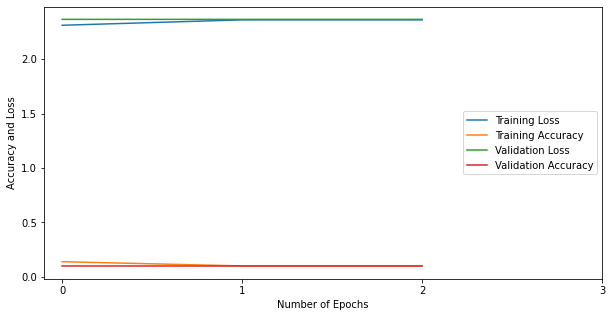

0.0963

In [31]:
new_metrics(optim='Adam',lr=0.001)

### From the above results we can see that we are not getting good results as it is overfitting and validation accuracy is not good, maybe because we haven't done normalization. Thus doing further experiments with our best parameters, optimizer as "Adam" and learning rate as 0.001, to see if the accuracy increases or not.

# **EXPERIMENT**

## Doing batch normalization without dropout

In [32]:
def new_network_b():
    new_model_2=nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), 
    nn.BatchNorm2d(32),
    nn.ReLU(),

    nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),  
    nn.BatchNorm2d(64),
    nn.ReLU(),
        
    nn.MaxPool2d(kernel_size=2, stride=2),  
             
    nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1), 
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
        
    nn.MaxPool2d(kernel_size=2, stride=2),       
        
    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),

    nn.Conv2d(512,256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
        
    nn.MaxPool2d(kernel_size=2, stride=2),       
        
    nn.Conv2d(256,128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(128,64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.Conv2d(64,32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
        
    nn.Flatten(),
    nn.Linear(32*4*4, 10),  
    nn.Softmax(dim=1)
    )

    classification_loss = nn.CrossEntropyLoss() # We usually use crossEntrophy loss for classification problems

    return new_model_2, classification_loss

In [33]:
# with test data
def new_metrics_b(optim, lr):
    train_loss_list=[]
    train_acc_list=[]
    val_loss_list=[]
    val_acc_list=[]
    
    new_model_2, classify_loss_net2 = new_network_b()
    optimizer=optimizers(model=new_model_2, opt=optim, learning_rate=lr)
    
    new_model_2 = new_model_2.to(device)

    for epoch in range(20):
        train_loss,train_acc=train(loader=train_loader, model=new_model_2, classify_loss=classify_loss_net2, opt=optimizer)
        
        val_loss,val_acc=validation(loader=valid_loader, model=new_model_2, classify_loss=classify_loss_net2, opt=optimizer)
       
        print("Epoch Number: ",epoch+1)
        print("\n\tTraining Loss: ",train_loss)
        print("\tTraining Accuracy: ",train_acc)
        
        print("\n\tValidation Loss",val_loss)
        print("\tValidation Accuracy",val_acc)

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, label="Training Loss")
    plt.plot(train_acc_list,label="Training Accuracy")
    plt.plot(val_loss_list, label="Validation Loss")
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy and Loss')
    plt.xticks(np.arange(0,21,1))
    plt.legend(loc='center right')
    plt.show()
    
    test_loss,test_acc = validation(loader=testloader, model=new_model_2, classify_loss=classify_loss_net2, opt=optimizer)
    print("\nAccuracy and Loss on testing data")
    print(f"Test Data Accuracy:{test_acc}|Loss on Test Data:{test_loss}")

Epoch Number:  1

	Training Loss:  2.070928992462158
	Training Accuracy:  0.38415

	Validation Loss 2.0141221056350123
	Validation Accuracy 0.4398
Epoch Number:  2

	Training Loss:  1.962235112094879
	Training Accuracy:  0.493875

	Validation Loss 1.9093039553767195
	Validation Accuracy 0.5474
Epoch Number:  3

	Training Loss:  1.9012640773773193
	Training Accuracy:  0.556125

	Validation Loss 1.8736125063210631
	Validation Accuracy 0.5848
Epoch Number:  4

	Training Loss:  1.866839277458191
	Training Accuracy:  0.591325

	Validation Loss 1.8937407990994926
	Validation Accuracy 0.5639
Epoch Number:  5

	Training Loss:  1.8344525733947754
	Training Accuracy:  0.62475

	Validation Loss 1.8235302173291532
	Validation Accuracy 0.6351
Epoch Number:  6

	Training Loss:  1.8100677379608154
	Training Accuracy:  0.64935

	Validation Loss 1.8127113424550991
	Validation Accuracy 0.6457
Epoch Number:  7

	Training Loss:  1.787805871105194
	Training Accuracy:  0.671325

	Validation Loss 1.782903835

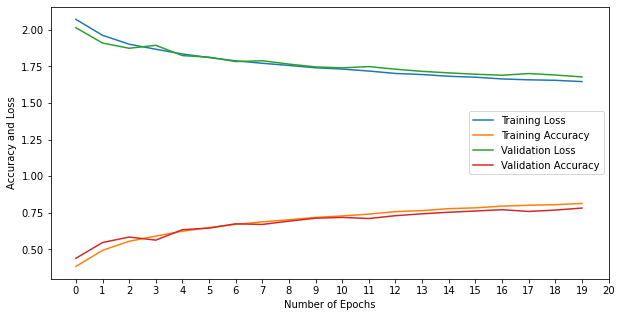


Accuracy and Loss on testing data
Test Data Accuracy:0.7812|Loss on Test Data:1.679246546361393


In [34]:
new_metrics_b(optim='Adam',lr=0.001)

## Network with Batch normalization and dropout

In [35]:
def new_network_b_d():
    new_model_3=nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), 
    nn.BatchNorm2d(32),
    nn.ReLU(),

    nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),  
    nn.BatchNorm2d(64),
    nn.ReLU(),
        
    nn.MaxPool2d(kernel_size=2, stride=2),  
         
    nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1), 
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
        
    nn.MaxPool2d(kernel_size=2, stride=2),
       
        
    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),

    nn.Conv2d(512,256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
        
    nn.MaxPool2d(kernel_size=2, stride=2),       
        
    nn.Conv2d(256,128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(128,64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.Conv2d(64,32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
        
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(),   # DROPOUT

    nn.Flatten(),    
    nn.Linear(32*2*2, 10),  
    nn.Softmax(dim=1)
    ).to(device)

    classification_loss = nn.CrossEntropyLoss() # We usually use crossEntrophy loss for classification problems

    return new_model_3, classification_loss

In [36]:
def new_metrics_b_d(optim,lr):
    
    train_loss_list=[]
    train_acc_list=[]
    val_loss_list=[]
    val_acc_list=[]
    
    model_b_d, classification_loss = new_network_b_d()
    optimizer=optimizers(model=model_b_d, opt=optim, learning_rate=lr)
    
    model_b_d = model_b_d.to(device)

    for epoch in range(20):
        train_loss,train_acc=train(loader=train_loader, model=model_b_d, classify_loss=classification_loss, opt=optimizer)
        
        val_loss,val_acc=validation(loader=valid_loader, model=model_b_d, classify_loss=classification_loss, opt=optimizer)
       
        print("Epoch Number: ",epoch+1)
        print("\n\tTraining Loss: ",train_loss)
        print("\tTraining Accuracy: ",train_acc)
        
        print("\n\tValidation Loss",val_loss)
        print("\tValidation Accuracy",val_acc)

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, label="Training Loss")
    plt.plot(train_acc_list,label="Training Accuracy")
    plt.plot(val_loss_list, label="Validation Loss")
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy and Loss')
    plt.xticks(np.arange(0,21,1))
    plt.legend(loc='center right')
    plt.show()    
    
    test_loss,test_acc = validation(loader=testloader, model=model_b_d, classify_loss=classification_loss, opt=optimizer)
    print('*************************************************************************')
    print("Accuracy and Loss on testing data")
    print(f"Accuracy on Test Data:{test_acc}|Loss on Test Data:{test_loss}")

Epoch Number:  1

	Training Loss:  2.0943594164848327
	Training Accuracy:  0.361975

	Validation Loss 1.9947040861787888
	Validation Accuracy 0.4631
Epoch Number:  2

	Training Loss:  1.9743035829544067
	Training Accuracy:  0.484125

	Validation Loss 1.9773449848254268
	Validation Accuracy 0.4769
Epoch Number:  3

	Training Loss:  1.9033167378425597
	Training Accuracy:  0.556325

	Validation Loss 1.8478794090283184
	Validation Accuracy 0.6099
Epoch Number:  4

	Training Loss:  1.8581287369728088
	Training Accuracy:  0.601675

	Validation Loss 1.843450268236593
	Validation Accuracy 0.6144
Epoch Number:  5

	Training Loss:  1.820237409591675
	Training Accuracy:  0.63925

	Validation Loss 1.8001761897303425
	Validation Accuracy 0.6588
Epoch Number:  6

	Training Loss:  1.7951788428306579
	Training Accuracy:  0.6648

	Validation Loss 1.779469878147966
	Validation Accuracy 0.6803
Epoch Number:  7

	Training Loss:  1.7750033470153808
	Training Accuracy:  0.685575

	Validation Loss 1.76684591

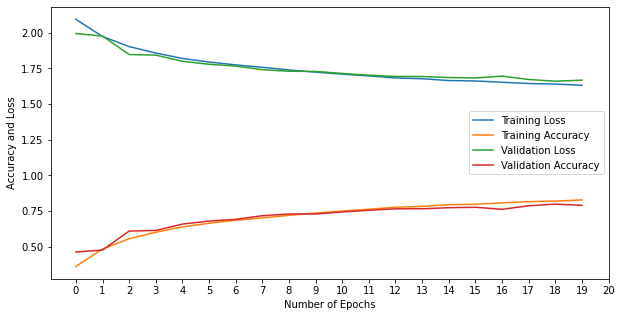

*************************************************************************
Accuracy and Loss on testing data
Accuracy on Test Data:0.7988|Loss on Test Data:1.6621002488242933


In [37]:
new_metrics_b_d('Adam',0.001)

# Alexnet

In [38]:
# downloading pretrained alexnet
alexnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True).to(device)
alexnet_model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [39]:
preprocess_alexnet = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


trainset_alexnet = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=preprocess_alexnet)

testset_alexnet = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=preprocess_alexnet)

testloader_alexnet = torch.utils.data.DataLoader(testset_alexnet, batch_size=32,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [40]:
# Getting Validation set for alexnet
val_size = 10000
train_size = len(trainset_alexnet) - val_size
train_data,val_data = random_split(trainset_alexnet,[train_size,val_size])

In [41]:
# train and validation loaders
trainloader_alexnet=torch.utils.data.DataLoader(train_data, batch_size=32,shuffle=True, num_workers=2)
valloader_alexnet=torch.utils.data.DataLoader(val_data, batch_size=32,shuffle=True, num_workers=2)

In [42]:
alexnet_model.classifier[4] = nn.Linear(4096,1024)
alexnet_model.classifier[6] = nn.Linear(1024,10)

In [43]:
alexnet_model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [44]:
# function before training
def predict_before_train(model=alexnet_model, device=device, test_loader=testloader_alexnet):
    corrects = 0
    total = 0
    model = model.to(device)
    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_inputs = test_inputs.to(device)
            test_labels = test_labels.to(device)
            test_outputs = model(test_inputs)
            test_preds = test_outputs.argmax(dim=1)
            total += test_labels.size(0)
            corrects += (test_preds==test_labels).sum().item()

    print('Accuracy of the network on the 10000 test images before training: %d %%' % (100 * corrects / total))

In [45]:
predict_before_train()

Accuracy of the network on the 10000 test images before training: 9 %


In [50]:
# function to train 
def alexnet_metrics(alex_model=alexnet_model):
    
    train_loss_list=[]
    train_acc_list=[]
    val_loss_list=[]
    val_acc_list=[]

    criterion_alexnet = nn.CrossEntropyLoss()
    optimizer_alexnet = optim.SGD(alexnet_model.parameters(), lr=0.001, momentum=0.9)    

    model_alex = alex_model.to(device)

    for epoch in range(5):
        train_loss,train_acc=train(loader=trainloader_alexnet, model=model_alex, classify_loss=criterion_alexnet, opt=optimizer_alexnet)
        
        val_loss,val_acc=validation(loader=valloader_alexnet, model=model_alex, classify_loss=criterion_alexnet, opt=optimizer_alexnet)
       
        print("Epoch Number: ",epoch+1)
        print("\n\tTraining Loss: ",train_loss)
        print("\tTraining Accuracy: ",train_acc)
        
        print("\n\tValidation Loss",val_loss)
        print("\tValidation Accuracy",val_acc)

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, label="Training Loss")
    plt.plot(train_acc_list,label="Training Accuracy")
    plt.plot(val_loss_list, label="Validation Loss")
    plt.plot(val_acc_list, label='Validation Accuracy')


    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy and Loss')
    plt.xticks(np.arange(0,5,1))
    plt.legend(loc='center right')
    plt.show()
    
    
    testalex_loss,testalex_acc=validation(loader=testloader_alexnet, model=model_alex, classify_loss=criterion_alexnet, opt=optimizer_alexnet)
    print('*************************************************************************')
    print("Accuracy and Loss on testing data after training")
    print(f"Accuracy on Test Data:{testalex_acc}|Loss on Test Data:{testalex_loss}")

Epoch Number:  1

	Training Loss:  1.1818314603805542
	Training Accuracy:  0.57735

	Validation Loss 1.1168286948920059
	Validation Accuracy 0.5975
Epoch Number:  2

	Training Loss:  1.1145417325019837
	Training Accuracy:  0.59905

	Validation Loss 1.1051680670378687
	Validation Accuracy 0.6089
Epoch Number:  3

	Training Loss:  1.0815610816955565
	Training Accuracy:  0.608175

	Validation Loss 1.073673986588804
	Validation Accuracy 0.6151
Epoch Number:  4

	Training Loss:  1.0536869166374208
	Training Accuracy:  0.61915

	Validation Loss 1.0405655093848134
	Validation Accuracy 0.6263
Epoch Number:  5

	Training Loss:  1.0378994866847993
	Training Accuracy:  0.623725

	Validation Loss 1.0395588210215583
	Validation Accuracy 0.6298


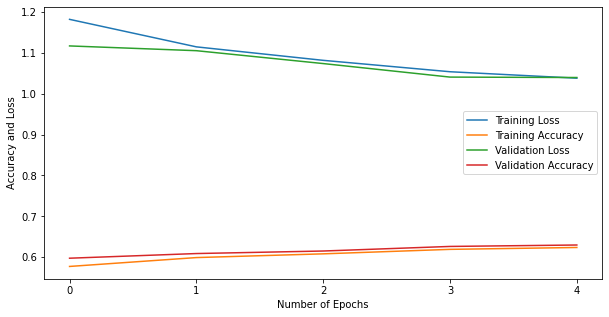

*************************************************************************
Accuracy and Loss on testing data after training
Accuracy on Test Data:0.6221|Loss on Test Data:1.044073254536516


In [51]:
alexnet_metrics()

# Resnet

In [52]:
from torchvision.models import ResNet18_Weights
resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18',weights=ResNet18_Weights.DEFAULT).to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [53]:
# Loading the data again because the preprocessing is different
preprocess_resnet = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainset_resnet = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=preprocess_resnet)

testset_resnet = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=preprocess_resnet)

testloader_resnet = torch.utils.data.DataLoader(testset_resnet, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [54]:
# Getting Validation set for resnet
val_size = 10000
train_size = len(trainset_resnet) - val_size
train_data,val_data = random_split(trainset_resnet,[train_size,val_size])

In [55]:
trainloader_resnet=torch.utils.data.DataLoader(train_data, batch_size=32,shuffle=True, num_workers=2)
valloader_resnet=torch.utils.data.DataLoader(val_data, batch_size=32,shuffle=True, num_workers=2)

In [56]:
resnet_model.fc = nn.Linear(512,10)

In [57]:
predict_before_train(model=resnet_model, device=device, test_loader=testloader_resnet)

Accuracy of the network on the 10000 test images before training: 7 %


In [64]:
def resnet_metrics(model_resnet=resnet_model):
  criterion_resnet = nn.CrossEntropyLoss()
  optimizer_resnet = optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9)
       
  train_loss_list=[]
  train_acc_list=[]
  val_loss_list=[]
  val_acc_list=[]
  model_resnet = model_resnet.to(device)

  for epoch in range(5):
    train_loss,train_acc=train(loader=trainloader_resnet, model=model_resnet, classify_loss=criterion_resnet, opt=optimizer_resnet)
        
    val_loss,val_acc=validation(loader=valloader_resnet, model=model_resnet, classify_loss=criterion_resnet, opt=optimizer_resnet)
       
    print("Epoch Number: ",epoch+1)
    print("\nTraining Loss: ",train_loss)
    print("Training Accuracy: ",train_acc)
        
    print("\nValidation Loss",val_loss)
    print("Validation Accuracy",val_acc)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

  plt.figure(figsize=[10,5])
  plt.plot(train_loss_list, label="Training Loss")
  plt.plot(train_acc_list,label="Training Accuracy")
  plt.plot(val_loss_list, label="Validation Loss")
  plt.plot(val_acc_list, label='Validation Accuracy')

  plt.xlabel("Number of Epochs")
  plt.ylabel("Accuracy and Loss")
  plt.xticks(np.arange(0,4,1))
  plt.legend(loc="center right")
  plt.show()
     
  testres_loss,testres_acc=validation(loader=testloader_resnet, model=model_resnet, classify_loss=criterion_resnet, opt=optimizer_resnet)
  print('**********************************************************************')
  print("Accuracy and Loss on testing data after training")
  print(f"Accuracy on Test Data:{testres_acc}|Loss on Test Data:{testres_loss}")

Epoch Number:  1

Training Loss:  0.021937684955401347
Training Accuracy:  0.99495

Validation Loss 0.1892809513208721
Validation Accuracy 0.9444
Epoch Number:  2

Training Loss:  0.015830900315451434
Training Accuracy:  0.9966

Validation Loss 0.18524386508043664
Validation Accuracy 0.9464
Epoch Number:  3

Training Loss:  0.011767278722440823
Training Accuracy:  0.99765

Validation Loss 0.18712733782375582
Validation Accuracy 0.9473
Epoch Number:  4

Training Loss:  0.00934931875881739
Training Accuracy:  0.99845

Validation Loss 0.18900195620552349
Validation Accuracy 0.9464
Epoch Number:  5

Training Loss:  0.006749583564698696
Training Accuracy:  0.998925

Validation Loss 0.19098596877478713
Validation Accuracy 0.9472


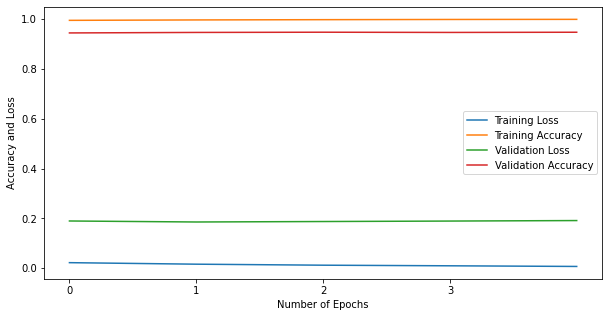

**********************************************************************
Accuracy and Loss on testing data after training
Accuracy on Test Data:0.9446|Loss on Test Data:0.20112360856710032


In [65]:
resnet_metrics()